# 2.1 Regularization: Dropout and L2

Regularization is a set of techniques used to prevent overfitting in neural networks and improve their generalization to unseen data. In this notebook, we will cover two of the most popular regularization methods: **L2 regularization** (also known as weight decay) and **Dropout**.

## Learning Objectives

- Understand the concept of overfitting and why regularization is important.
- Learn how L2 regularization and Dropout work, both mathematically and intuitively.
- Implement and compare both techniques using TensorFlow and PyTorch.
- Apply regularization to a real-world dataset (MNIST) and observe its effects.

---

## Overfitting, Underfitting, and the Need for Regularization

When training neural networks, we want our models to perform well not only on the training data but also on new, unseen data. Two common problems can arise:

- **Underfitting**: The model is too simple to capture the underlying patterns in the data.
- **Overfitting**: The model learns the training data too well, including its noise, and fails to generalize to new data.

Regularization helps to reduce overfitting by constraining the model's capacity or introducing randomness during training.

![Overfitting vs Underfitting](https://upload.wikimedia.org/wikipedia/commons/1/19/Overfitting.svg)

*Figure: Underfitting, Good Fit, and Overfitting*

---

## L2 Regularization (Weight Decay)

L2 regularization adds a penalty to the loss function proportional to the sum of the squared weights. This discourages the network from relying too heavily on any single weight, leading to simpler models that generalize better.

**Mathematical Formulation:**

$$
L_{total} = L_{data} + \lambda \sum_{i} w_i^2
$$

Where:
- $L_{data}$ is the original loss (e.g., cross-entropy)
- $w_i$ are the model weights
- $\lambda$ is the regularization strength (hyperparameter)

**Intuition:**
- Penalizes large weights
- Encourages the model to spread "responsibility" across many weights
- Helps prevent overfitting

## Dropout Regularization

Dropout is a technique where, during training, a random subset of neurons is "dropped out" (set to zero) at each iteration. This prevents the network from becoming too reliant on any particular neuron and encourages redundancy and robustness.

**How Dropout Works:**
- During each training step, each neuron's output is set to zero with probability $p$ (the dropout rate).
- During inference (testing), all neurons are used, but their outputs are scaled by $(1-p)$ to account for the missing activations during training.

**Intuition:**
- Forces the network to learn redundant representations
- Reduces co-adaptation of neurons
- Acts as a form of model averaging

---

## The MNIST Dataset

For our experiments, we will use the **MNIST** dataset, a classic benchmark in machine learning. MNIST consists of 70,000 grayscale images of handwritten digits (0-9), each of size 28x28 pixels.

- **Training set:** 60,000 images
- **Test set:** 10,000 images
- **Classes:** 10 (digits 0 to 9)

Each image is labeled with the correct digit. The task is to classify each image into the correct digit class.

Let's load and visualize some examples.

2025-08-06 13:04:44.730363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 13:04:44.832904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754496284.868261  533212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754496284.878295  533212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754496284.946025  533212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)


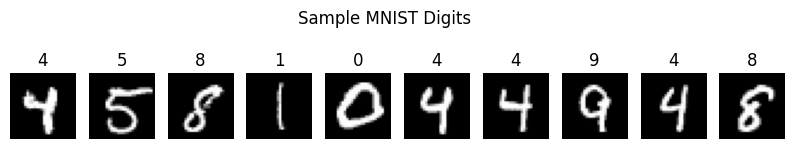

In [1]:
# Load and visualize MNIST dataset
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and PyTorch have built-in MNIST loaders
try:
    from tensorflow.keras.datasets import mnist as tf_mnist
except ImportError:
    tf_mnist = None
try:
    import torch
    from torchvision import datasets, transforms
except ImportError:
    torch = None

# Load MNIST using TensorFlow (for demonstration)
if tf_mnist is not None:
    (x_train, y_train), (x_test, y_test) = tf_mnist.load_data()
    print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
    # Show 10 random images
    plt.figure(figsize=(10,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        idx = np.random.randint(0, x_train.shape[0])
        plt.imshow(x_train[idx], cmap='gray')
        plt.axis('off')
        plt.title(str(y_train[idx]))
    plt.suptitle('Sample MNIST Digits')
    plt.show()
else:
    print('TensorFlow not installed. Skipping MNIST visualization.')

---

## L2 Regularization in TensorFlow

Let's implement a simple neural network for MNIST classification using TensorFlow, first **without** and then **with** L2 regularization. We will compare the results to see the effect of regularization.


Training model: No L2


/media/kmom/Data/github/kmom88/zero-to-hero-AI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-06 13:05:11.917459: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-08-06 13:05:11.917479: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-06 13:05:11.917482: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: ASUS-F15
2025-08-06 13:05:11.9174

Test accuracy: 0.9736

Training model: L2=1e-4
Test accuracy: 0.9742


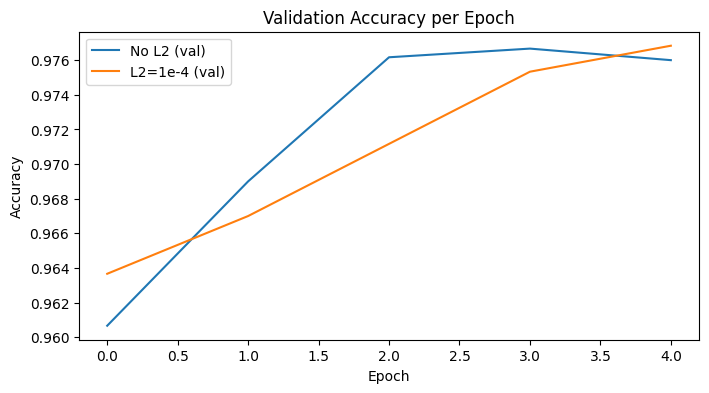

In [2]:
# TensorFlow: MLP for MNIST with and without L2 regularization
import tensorflow as tf

# Prepare data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Model definition function
def build_model(l2_lambda=0.0):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Train and evaluate models
results = {}
for l2_lambda, label in zip([0.0, 1e-4], ['No L2', 'L2=1e-4']):
    print(f'\nTraining model: {label}')
    model = build_model(l2_lambda)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results[label] = {'history': history, 'test_acc': test_acc}
    print(f'Test accuracy: {test_acc:.4f}')

# Plot training/validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
for label, res in results.items():
    plt.plot(res['history'].history['val_accuracy'], label=f'{label} (val)')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Dropout in TensorFlow

Now let's add Dropout to our model. Dropout is typically applied after activation functions in hidden layers. We'll compare the results with and without Dropout.


Training model: No Dropout
Test accuracy: 0.9773

Training model: Dropout=0.25
Test accuracy: 0.9774


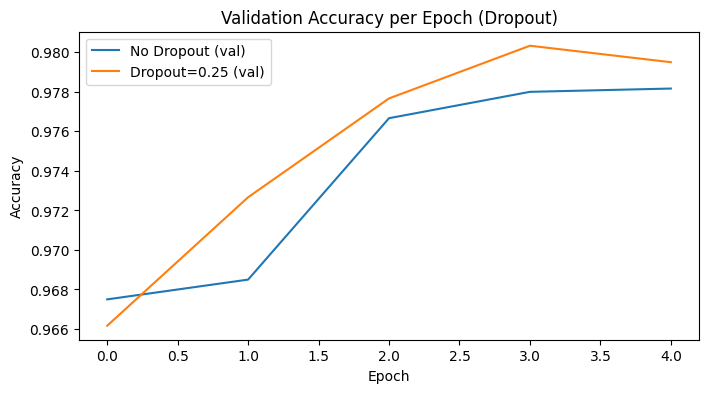

In [3]:
# TensorFlow: MLP for MNIST with and without Dropout
def build_model_dropout(dropout_rate=0.0):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

results_dropout = {}
for dropout_rate, label in zip([0.0, 0.25], ['No Dropout', 'Dropout=0.25']):
    print(f'\nTraining model: {label}')
    model = build_model_dropout(dropout_rate)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results_dropout[label] = {'history': history, 'test_acc': test_acc}
    print(f'Test accuracy: {test_acc:.4f}')

plt.figure(figsize=(8,4))
for label, res in results_dropout.items():
    plt.plot(res['history'].history['val_accuracy'], label=f'{label} (val)')
plt.title('Validation Accuracy per Epoch (Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## L2 Regularization and Dropout in PyTorch

Now let's implement the same experiments in PyTorch. We'll build a simple MLP for MNIST, first without regularization, then with L2 (weight decay), and finally with Dropout.


Training: No Reg


/media/kmom/Data/github/kmom88/zero-to-hero-AI/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1: Train acc=0.9073, Test acc=0.9478
Epoch 2: Train acc=0.9594, Test acc=0.9667
Epoch 3: Train acc=0.9725, Test acc=0.9732
Epoch 4: Train acc=0.9800, Test acc=0.9769
Epoch 5: Train acc=0.9843, Test acc=0.9776

Training: L2=1e-4
Epoch 1: Train acc=0.9022, Test acc=0.9493
Epoch 2: Train acc=0.9598, Test acc=0.9665
Epoch 3: Train acc=0.9721, Test acc=0.9734
Epoch 4: Train acc=0.9795, Test acc=0.9750
Epoch 5: Train acc=0.9838, Test acc=0.9746

Training: Dropout=0.5
Epoch 1: Train acc=0.8448, Test acc=0.9427
Epoch 2: Train acc=0.9323, Test acc=0.9610
Epoch 3: Train acc=0.9468, Test acc=0.9654
Epoch 4: Train acc=0.9533, Test acc=0.9699
Epoch 5: Train acc=0.9583, Test acc=0.9733


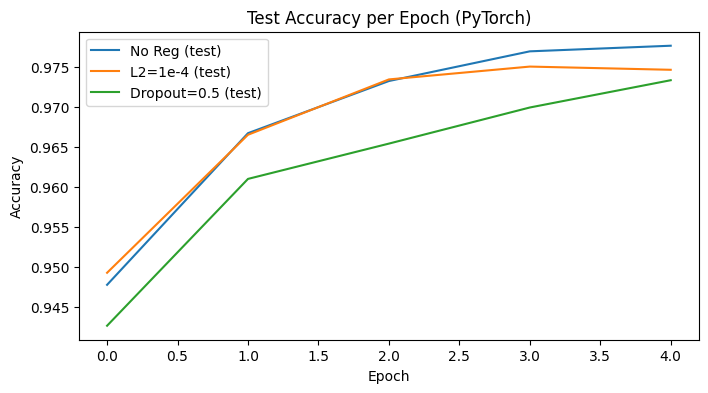

In [4]:
# PyTorch: MLP for MNIST with and without L2 and Dropout
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Prepare data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class MLP(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_model(dropout=0.0, weight_decay=0.0, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MLP(dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_accs.append(correct/total)
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_accs.append(correct/total)
        print(f"Epoch {epoch+1}: Train acc={train_accs[-1]:.4f}, Test acc={val_accs[-1]:.4f}")
    return train_accs, val_accs

# Run experiments
configs = [
    {'dropout': 0.0, 'weight_decay': 0.0, 'label': 'No Reg'},
    {'dropout': 0.0, 'weight_decay': 1e-4, 'label': 'L2=1e-4'},
    {'dropout': 0.5, 'weight_decay': 0.0, 'label': 'Dropout=0.5'}
]
results = {}
for cfg in configs:
    print(f"\nTraining: {cfg['label']}")
    train_acc, val_acc = train_model(dropout=cfg['dropout'], weight_decay=cfg['weight_decay'])
    results[cfg['label']] = {'train_acc': train_acc, 'val_acc': val_acc}

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
for label, res in results.items():
    plt.plot(res['val_acc'], label=f'{label} (test)')
plt.title('Test Accuracy per Epoch (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Summary and Practical Recommendations

- **L2 regularization** (weight decay) penalizes large weights and helps prevent overfitting by encouraging simpler models.
- **Dropout** randomly disables neurons during training, forcing the network to learn redundant representations and improving robustness.
- Both techniques are easy to implement in modern deep learning frameworks (TensorFlow, PyTorch).
- The optimal regularization strength (L2 lambda, dropout rate) should be tuned for each problem.

**In practice:**
- Use L2 regularization by default for most neural networks.
- Add Dropout for larger or deeper networks, especially when overfitting is observed.
- Always monitor validation accuracy/loss to detect overfitting and the effect of regularization.

---